In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
44149,NaN,NaN,International,2020-09-14,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44150,NaN,NaN,International,2020-09-15,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44151,NaN,NaN,International,2020-09-16,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


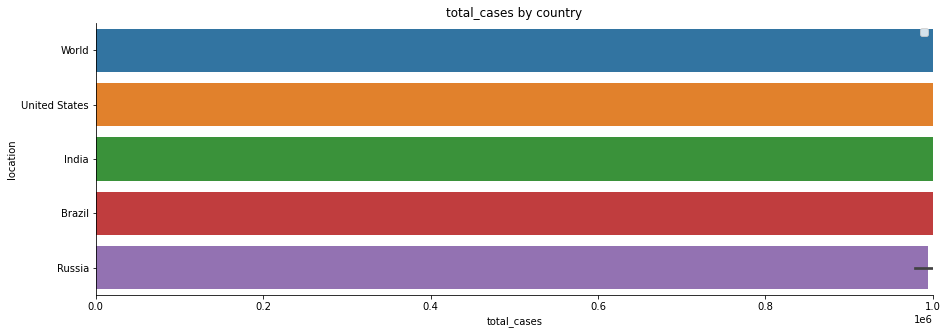

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


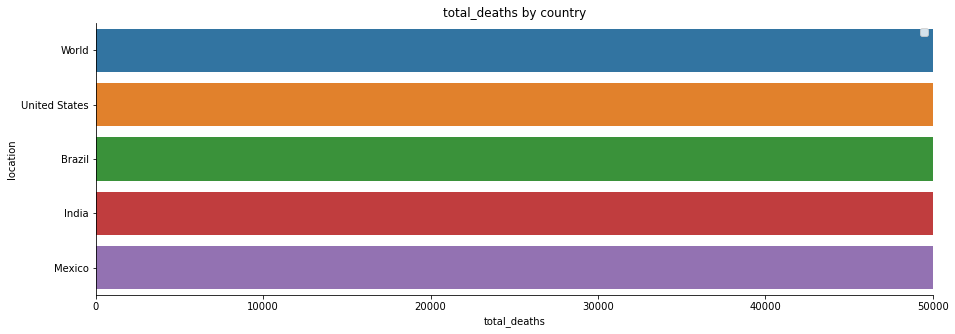

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


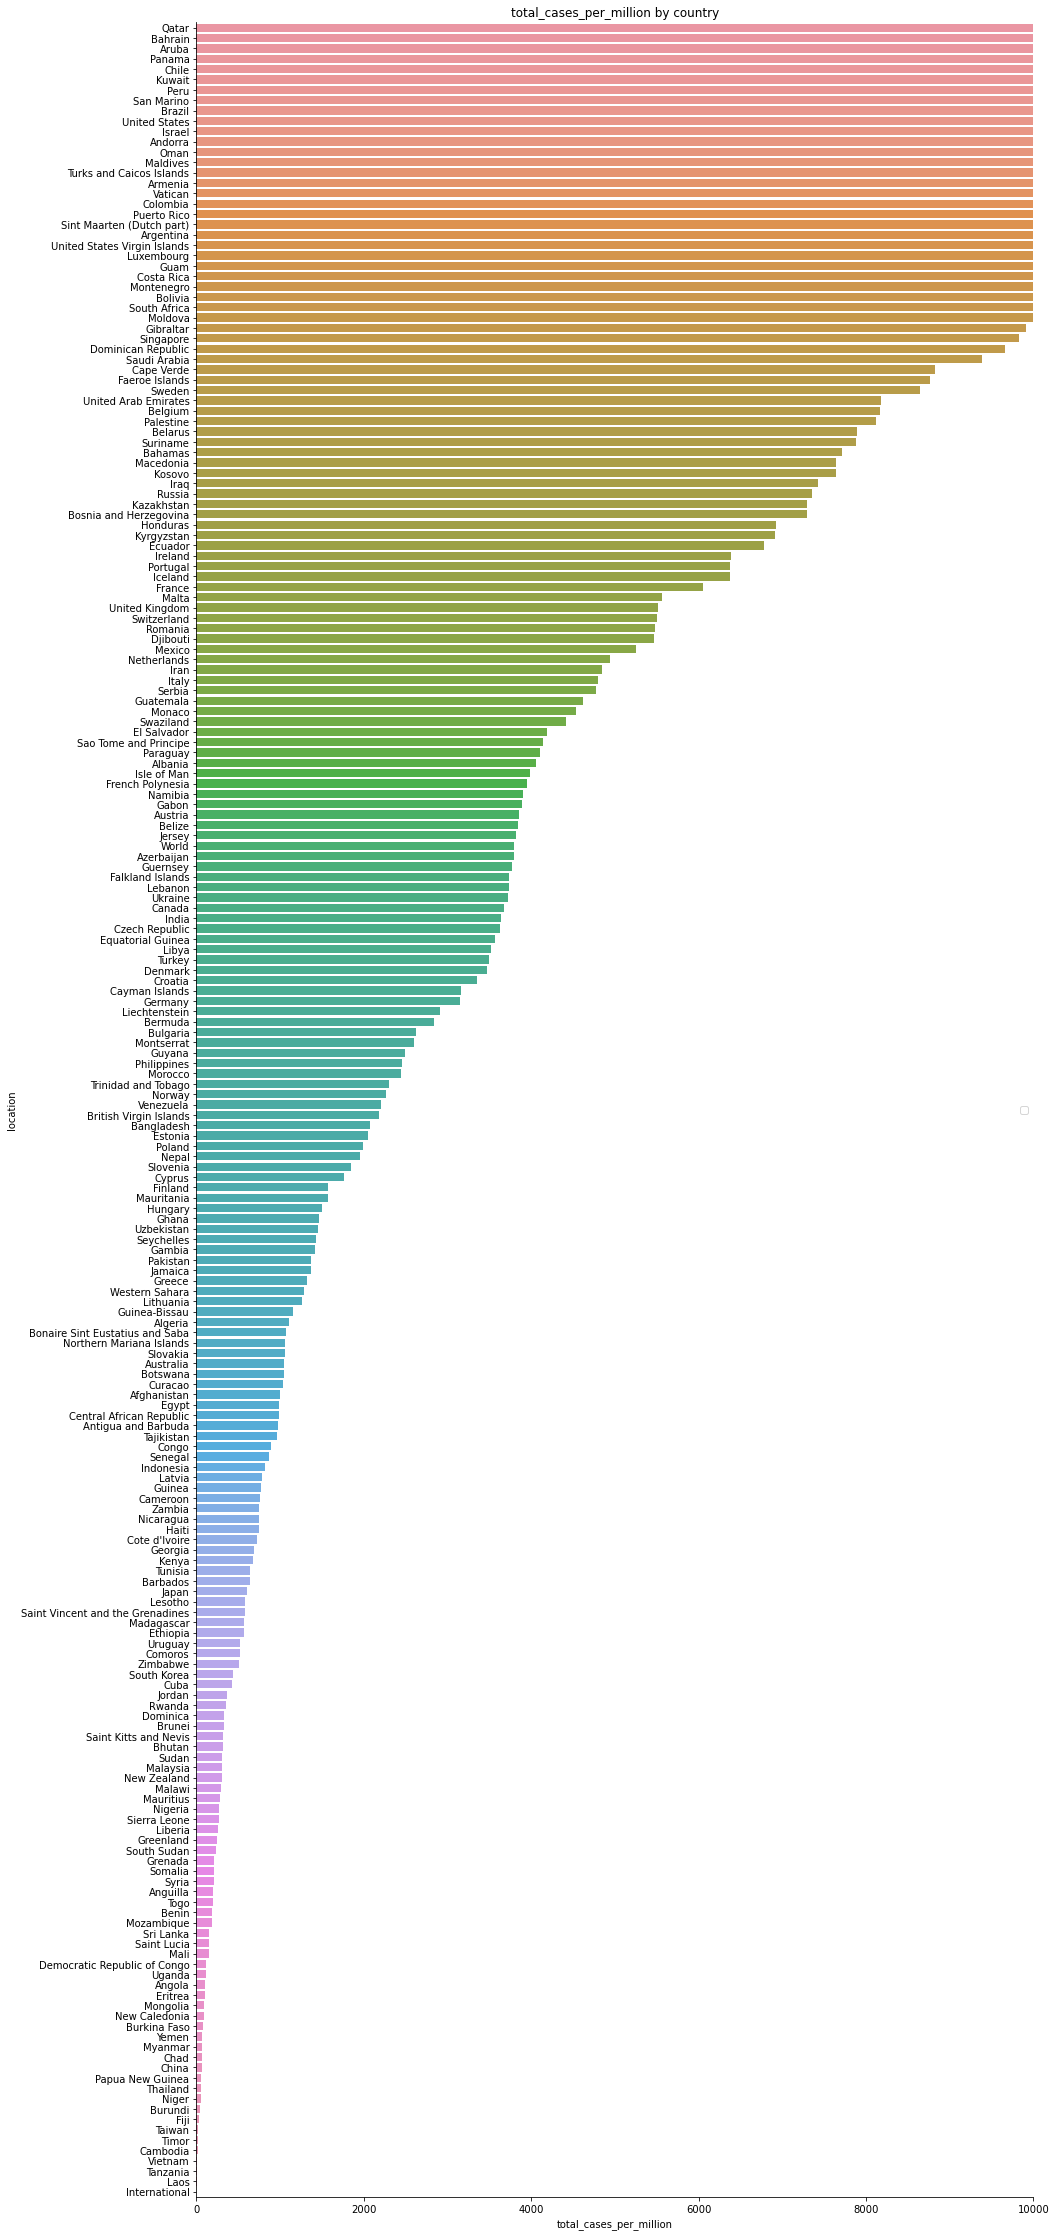

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


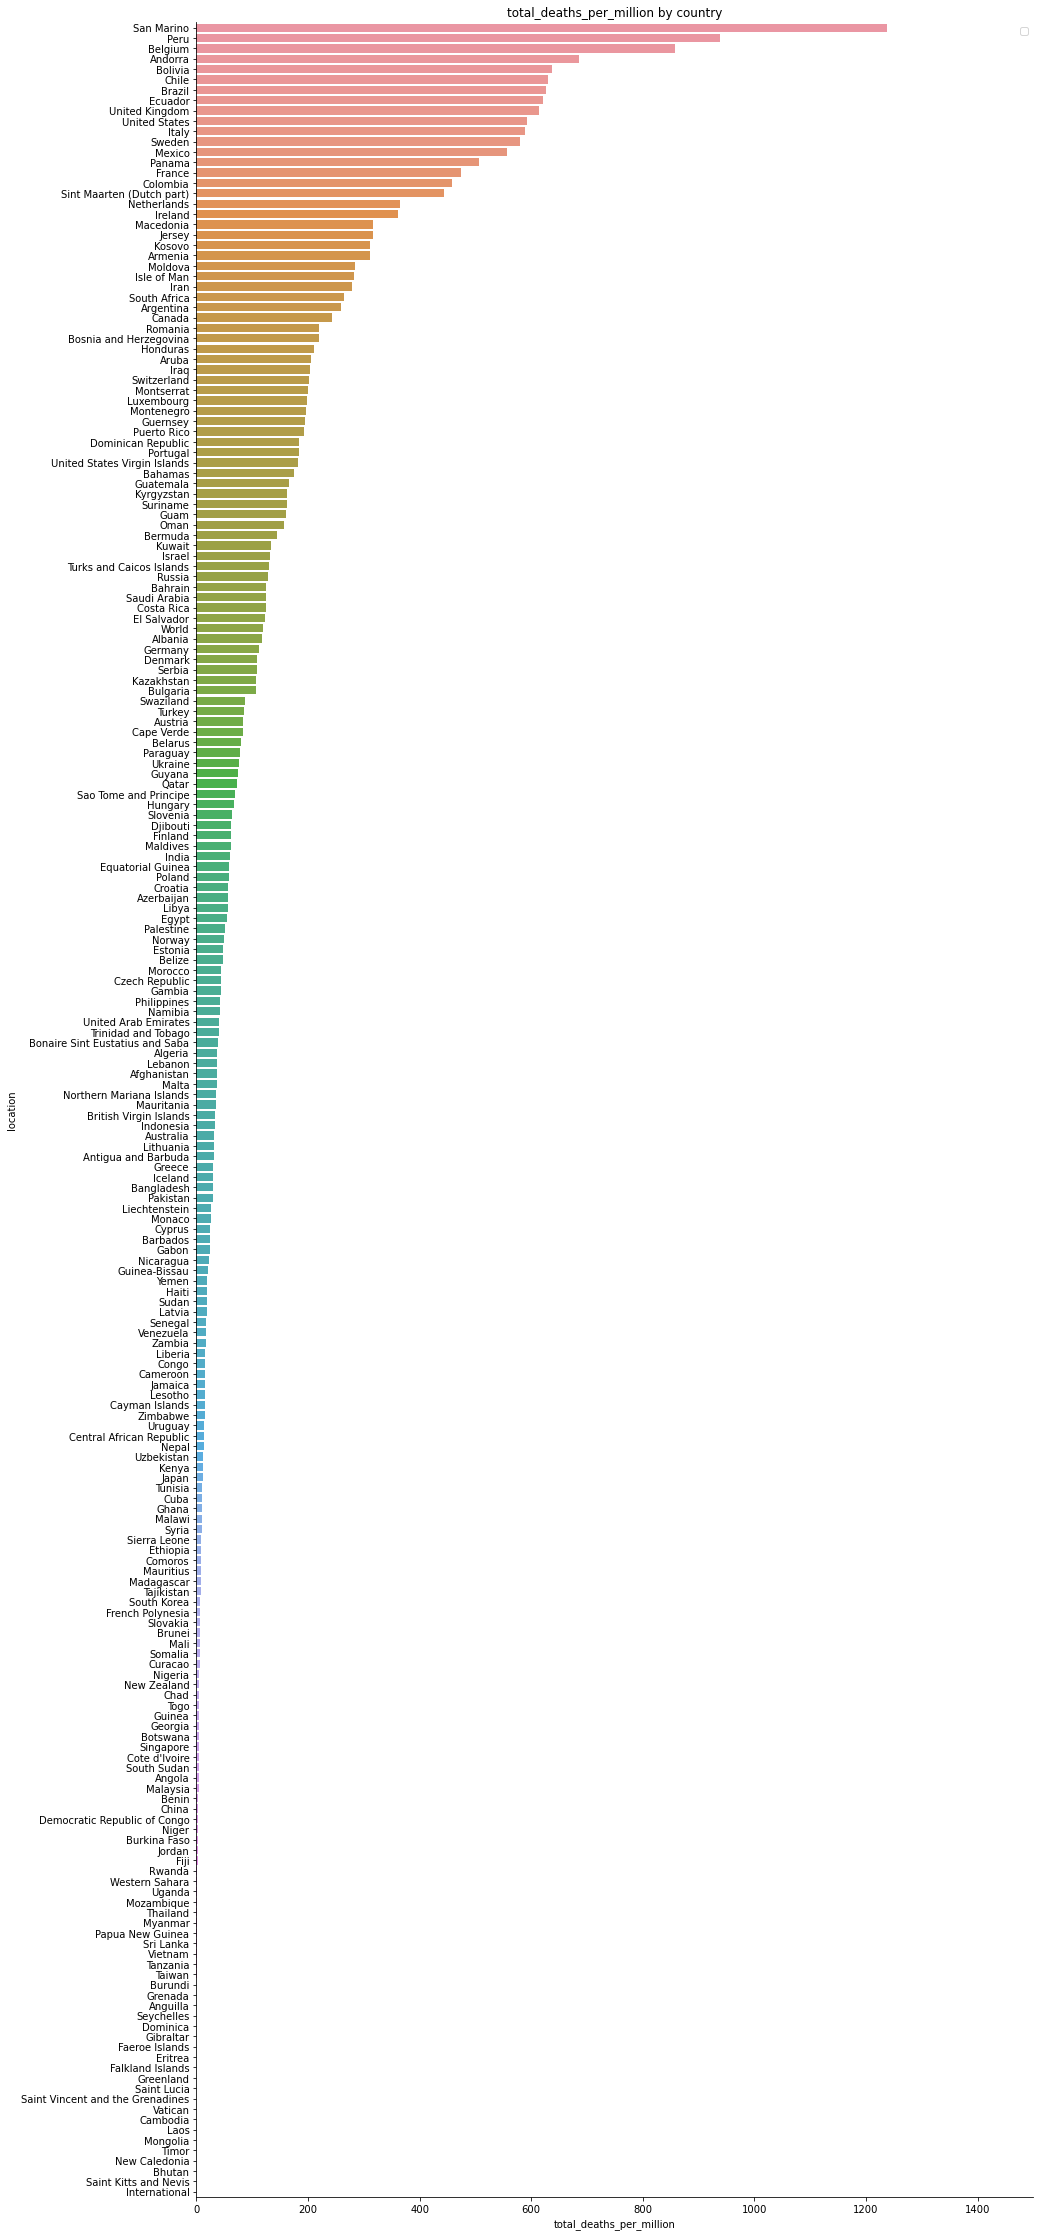

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

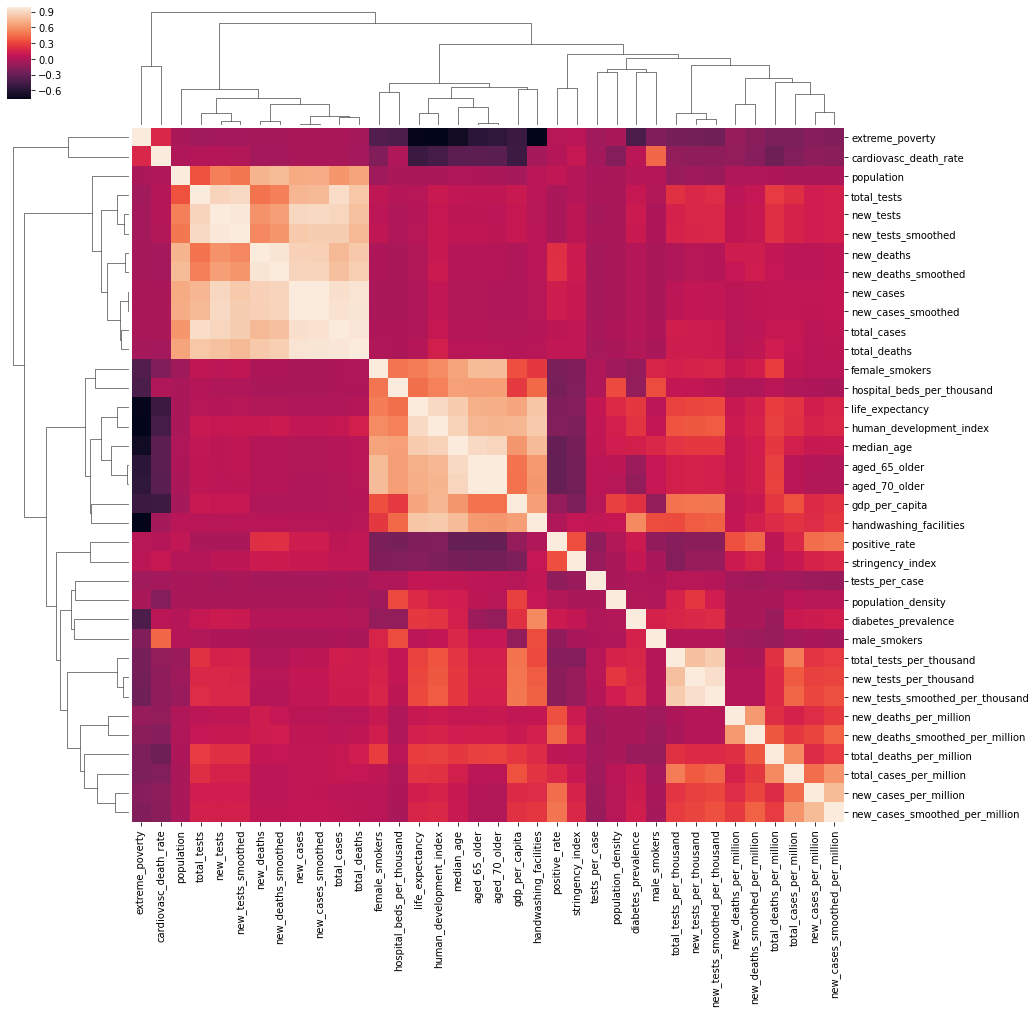

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9988201764942667 (+/- 0.0014504964541888472)
Coef :  [1.03287067e+00 8.79905918e-05 9.19640182e-05]
3 Last_days :  [[29078936 29320128 29611395]]
Today :  29611395
Prediction + :  527422
Tomorow :  30138817
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996853773835395 (+/- 9.932587180349386e-05)
Coef :  [0.17413058 0.40532121 0.43070029]
3 Last_days :  [[924817 929050 935767]]
Today :  935767
Prediction + :  7979
Tomorow :  943746
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5474447363611886 (+/- 0.6359915327301701)
Coef :  [-0.7495607   0.79178563  0.96176666]
3 Last_days :  [[381094 387252 395104]]
Today :  395104
Prediction + :  5891
Tomorow :  400995
                                     
--------- Total Death -----------------
                                     
R^2: 0.9875113450623868 (+/- 0.008743121272175967)
Coef :  [-0.74842398  0.78845195  0.9589461 ]
3 Last_days :  [[30916 30950 30999]]
Today :  30999
Prediction + :  45
Tomorow :  31044
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9548141413391941 (+/- 0.03934490160256521)
Coef :  [-0.32857329 -0.01280615  1.33564503]
3 Last_days :  [[90197 90219 90243]]
Today :  90243
Prediction + :  25
Tomorow :  90268
                                     
--------- Total Death -----------------
                                     
R^2: -82.6057866819793 (+/- 118.13311927200026)
Coef :  [-0.07744702  0.01247056  1.05674091]
3 Last_days :  [[4734 4735 4736]]
Today :  4736
Prediction + :  5
Tomorow :  4741
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9451120369624245 (+/- 0.0766290169288162)
Coef :  [-0.81621701  0.89467123  0.92090872]
3 Last_days :  [[287753 288761 289990]]
Today :  289990
Prediction + :  940
Tomorow :  290930
                                     
--------- Total Death -----------------
                                     
R^2: 0.9401214303810249 (+/- 0.06275547758114589)
Coef :  [-0.82245724  0.8966237   0.92486428]
3 Last_days :  [[35610 35624 35633]]
Today :  35633
Prediction + :  31
Tomorow :  35664
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5922705994724918 (+/- 0.5675337703325172)
Coef :  [-0.31611446  0.16162416  1.16090808]
3 Last_days :  [[566326 593730 603167]]
Today :  603167
Prediction + :  14104
Tomorow :  617271
                                     
--------- Total Death -----------------
                                     
R^2: -0.07048797853916085 (+/- 1.2158687449334862)
Coef :  [-0.72945     0.63877362  1.08971662]
3 Last_days :  [[29747 29848 30004]]
Today :  30004
Prediction + :  97
Tomorow :  30101
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9656905388813369 (+/- 0.04748252264358252)
Coef :  [0.08958598 0.45738649 0.46599053]
3 Last_days :  [[6519979 6554820 6606293]]
Today :  6606293
Prediction + :  71166
Tomorow :  6677459
                                     
--------- Total Death -----------------
                                     
R^2: 0.9949378561021168 (+/- 0.005932131296128321)
Coef :  [-0.43851197  0.6864054   0.75484738]
3 Last_days :  [[194079 194530 195937]]
Today :  195937
Prediction + :  796
Tomorow :  196733
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9444344352492813 (+/- 0.0780038060027568)
Coef :  [-0.68375379  0.83059918  0.8537844 ]
3 Last_days :  [[368504 371125 374228]]
Today :  374228
Prediction + :  2153
Tomorow :  376381
                                     
--------- Total Death -----------------
                                     
R^2: 0.2750886288936008 (+/- 0.9831425187468539)
Coef :  [-0.76637084  0.83054222  0.93511405]
3 Last_days :  [[41628 41637 41664]]
Today :  41664
Prediction + :  39
Tomorow :  41703
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.3218932932156387 (+/- 0.9580457927987909)
Coef :  [-0.78214953  0.85107375  0.93092664]
3 Last_days :  [[260355 261762 263663]]
Today :  263663
Prediction + :  1251
Tomorow :  264914
                                     
--------- Total Death -----------------
                                     
R^2: 0.2830685668081293 (+/- 1.003035219069983)
Coef :  [-0.78581197  0.83964076  0.94540805]
3 Last_days :  [[9350 9362 9368]]
Today :  9368
Prediction + :  15
Tomorow :  9383
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9560412518387776 (+/- 0.06028548285801116)
Coef :  [0.29722759 0.35825821 0.35511984]
3 Last_days :  [[402029 404648 407353]]
Today :  407353
Prediction + :  3333
Tomorow :  410686
                                     
--------- Total Death -----------------
                                     
R^2: 0.9660593130506597 (+/- 0.04738461623578049)
Coef :  [0.08789898 0.46684636 0.45597819]
3 Last_days :  [[23157 23313 23453]]
Today :  23453
Prediction + :  225
Tomorow :  23678
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9994875546853521 (+/- 0.0004801396481469669)
Coef :  [-0.66429848  0.81548619  0.84621427]
3 Last_days :  [[291162 292878 294620]]
Today :  294620
Prediction + :  1332
Tomorow :  295952
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993952159933664 (+/- 0.0003747313257510593)
Coef :  [-0.81350858  0.89343884  0.91800545]
3 Last_days :  [[7056 7119 7186]]
Today :  7186
Prediction + :  50
Tomorow :  7236
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9898305566246451 (+/- 0.00907134516952168)
Coef :  [-0.15919647  0.51895697  0.65277161]
3 Last_days :  [[4330455 4345610 4382263]]
Today :  4382263
Prediction + :  51836
Tomorow :  4434099
                                     
--------- Total Death -----------------
                                     
R^2: 0.4671737409906176 (+/- 0.7480782763523807)
Coef :  [-0.07060967  0.50149675  0.57971303]
3 Last_days :  [[131625 132006 133119]]
Today :  133119
Prediction + :  1271
Tomorow :  134390
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(29611395, 935767, 30138817, 943746),
 (395104, 30999, 400995, 31044),
 (289990, 35633, 290930, 35664),
 (603167, 30004, 617271, 30101),
 (6606293, 195937, 6677459, 196733),
 (90243, 4736, 90268, 4741),
 (374228, 41664, 376381, 41703),
 (263663, 9368, 264914, 9383),
 (407353, 23453, 410686, 23678),
 (294620, 7186, 295952, 7236),
 (4382263, 133119, 4434099, 134390)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-16,France,400995.0,0.0,31044.0,0.0,0.0,0.0
0,2020-09-16,China,90268.0,0.0,4741.0,0.0,0.0,0.0
0,2020-09-16,Italy,290930.0,0.0,35664.0,0.0,0.0,0.0
0,2020-09-16,Spain,617271.0,0.0,30101.0,0.0,0.0,0.0
0,2020-09-16,United States,6677459.0,0.0,196733.0,0.0,0.0,0.0
0,2020-09-16,World,30138817.0,0.0,943746.0,0.0,0.0,0.0
0,2020-09-16,United Kingdom,376381.0,0.0,41703.0,0.0,0.0,0.0
0,2020-09-16,Germany,264914.0,0.0,9383.0,0.0,0.0,0.0
0,2020-09-16,Iran,410686.0,0.0,23678.0,0.0,0.0,0.0
0,2020-09-16,Turkey,295952.0,0.0,7236.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")